# Matplotlib: Render math equations using TeX (mathtext)
- Nov 10, 2020
- Ref: 
    - [Text rendering with LaTex](https://matplotlib.org/tutorials/text/usetex.html)
    - [Example](https://matplotlib.org/gallery/text_labels_and_annotations/tex_demo.html)
        
        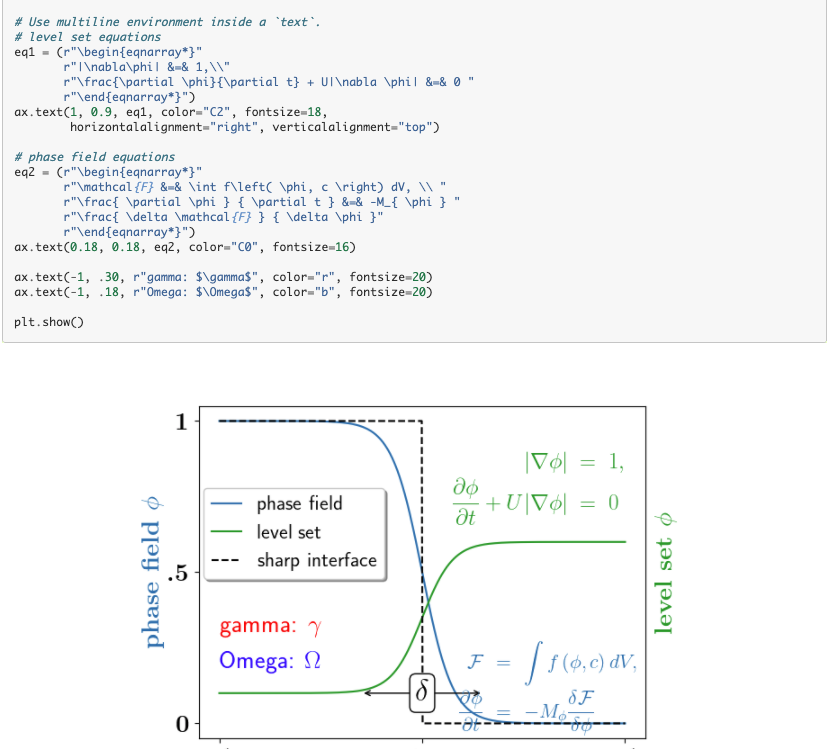
        
    

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %reset out

In [3]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt

Text(0.5, 1.0, '\\TeX\\ is Number $\\displaystyle\\sum_{n=1}^\\infty\\frac{-e^{i\\pi}}{2^n}$!')

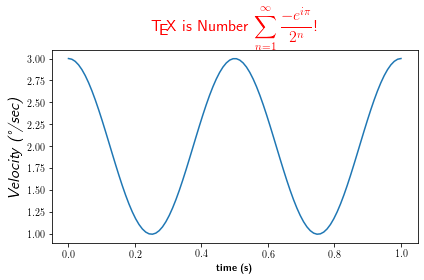

In [3]:
# Example 1
t = np.linspace(0.0, 1.0, 100)
s = np.cos(4 * np.pi * t) + 2

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(t, s)

ax.set_xlabel(r'\textbf{time (s)}')
ax.set_ylabel('\\textit{Velocity (\N{DEGREE SIGN}/sec)}', fontsize=16)
ax.set_title(r'\TeX\ is Number $\displaystyle\sum_{n=1}^\infty'
             r'\frac{-e^{i\pi}}{2^n}$!', fontsize=16, color='r')

In [13]:
# Example 2
f, ax = plt.subplots()
title=r'\begin{bmatrix}1 & 2 & 3\\ a & b & c \end{bmatrix}'
# title=(
#      r"$\displaystyle\begin{matrix}"
#       r"1 & 2 & 3\\"
#       r"a & b & c"
#       r"\end{matrix}$" 
#       )
# title=(
#     r"\begin{array}"
#     r"1.23\\"
#    r"23.46\\"
#   r"456.23\\"
#     r"8.24"
# r"\end{array}"
# )
ax.plot(t, s)

ax.set_title(title)

Text(0.5, 1.0, '\\begin{bmatrix}1 & 2 & 3\\\\ a & b & c \\end{bmatrix}')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fa6ccbda3b0> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'\\\\begin{bmatrix}1 & 2 & 3\\\\\\\\ a & b & c \\\\end{bmatrix}'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode
(/home/hayley/.cache/matplotlib/tex.cache/b24f8d76ac4965df2c313691ccbdc0ae.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file b24f8d76ac4965df2c313691ccbdc0ae.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Environment bmatrix undefined.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.19 {\sffamily \begin{bmatrix}
                               1 & 2 & 3\\ a & b & c \end{bmatrix}}
No pages of output.
Transcript written on b24f8d76ac4965df2c313691ccbdc0ae.log.




RuntimeError: latex was not able to process the following string:
b'\\\\begin{bmatrix}1 & 2 & 3\\\\\\\\ a & b & c \\\\end{bmatrix}'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode
(/home/hayley/.cache/matplotlib/tex.cache/b24f8d76ac4965df2c313691ccbdc0ae.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(./b24f8d76ac4965df2c313691ccbdc0ae.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Environment bmatrix undefined.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.19 {\sffamily \begin{bmatrix}
                               1 & 2 & 3\\ a & b & c \end{bmatrix}}
No pages of output.
Transcript written on b24f8d76ac4965df2c313691ccbdc0ae.log.




<Figure size 432x288 with 1 Axes>

$$\begin{bmatrix}
1 & 2 & 3\\ 
a & b & c 
\end{bmatrix}$$
$$\begin{array}
    1.23 &   23.46\\
  456.23 &    8.24
\end{array}\begin{array}
    1.23 &   23.46\\
  456.23 &    8.24
\end{array}$$

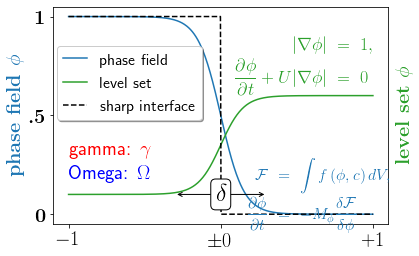

In [6]:
# More complex example
fig, ax = plt.subplots()
# interface tracking profiles
N = 500
delta = 0.6
X = np.linspace(-1, 1, N)
ax.plot(X, (1 - np.tanh(4 * X / delta)) / 2,    # phase field tanh profiles
        X, (1.4 + np.tanh(4 * X / delta)) / 4, "C2",  # composition profile
        X, X < 0, "k--")                        # sharp interface

# legend
ax.legend(("phase field", "level set", "sharp interface"),
          shadow=True, loc=(0.01, 0.48), handlelength=1.5, fontsize=16)

# the arrow
ax.annotate("", xy=(-delta / 2., 0.1), xytext=(delta / 2., 0.1),
            arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"))
ax.text(0, 0.1, r"$\delta$",
        color="black", fontsize=24,
        horizontalalignment="center", verticalalignment="center",
        bbox=dict(boxstyle="round", fc="white", ec="black", pad=0.2))

# Use tex in labels
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(["$-1$", r"$\pm 0$", "$+1$"], color="k", size=20)

# Left Y-axis labels, combine math mode and text mode
ax.set_ylabel(r"\bf{phase field} $\phi$", color="C0", fontsize=20)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([r"\bf{0}", r"\bf{.5}", r"\bf{1}"], color="k", size=20)

# Right Y-axis labels
ax.text(1.02, 0.5, r"\bf{level set} $\phi$",
        color="C2", fontsize=20, rotation=90,
        horizontalalignment="left", verticalalignment="center",
        clip_on=False, transform=ax.transAxes)

# Use multiline environment inside a `text`.
# level set equations
eq1 = (r"\begin{eqnarray*}"
       r"|\nabla\phi| &=& 1,\\"
       r"\frac{\partial \phi}{\partial t} + U|\nabla \phi| &=& 0 "
       r"\end{eqnarray*}")
ax.text(1, 0.9, eq1, color="C2", fontsize=18,
        horizontalalignment="right", verticalalignment="top")

# phase field equations
eq2 = (r"\begin{eqnarray*}"
       r"\mathcal{F} &=& \int f\left( \phi, c \right) dV, \\ "
       r"\frac{ \partial \phi } { \partial t } &=& -M_{ \phi } "
       r"\frac{ \delta \mathcal{F} } { \delta \phi }"
       r"\end{eqnarray*}")
ax.text(0.18, 0.18, eq2, color="C0", fontsize=16)

ax.text(-1, .30, r"gamma: $\gamma$", color="r", fontsize=20)
ax.text(-1, .18, r"Omega: $\Omega$", color="b", fontsize=20)

plt.show()